In [1]:
# import the needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [2]:
# variables and spesific parameters and constants
basic_breathing_factor_dict = [
    {"mean": {"16-31": 1.2e-02}},
    {"percentile":{"16-31": 1.6e-02}}
]
relative_breathing_factor_16_31 = (basic_breathing_factor_dict[1]["percentile"]["16-31"]* 60) / (basic_breathing_factor_dict[0]["mean"]["16-31"]* 60)
basic_quanta_exhalation_rate_listening = 1.0
quanta_exhalation_rate_speaking = 5.7
total_number_of_people = 21
relative_quanta_exhalation_rate = basic_quanta_exhalation_rate_listening / ((basic_quanta_exhalation_rate_listening * (total_number_of_people - 1) + quanta_exhalation_rate_speaking) / total_number_of_people)
mask_efficiency = {"Keine Maske": 0, "FFP2 Maske ohne Anp.":  1 - 0.532, "FFP2 Maske mit Anp.": 1 - 0.125, "FFP2 Maske und chirurgische Maske": 1 - 0.209, "FFP2 Maske mit festh. Band": 1 - 0.023, "chirurgische Maske": 1 - 0.76} # best case scenario
fraction_of_people_with_mask = [1, 0.75, 0.5, 0.25]
infected_people = 1
fraction_of_immune_people = 0.462
susceptible_people = (total_number_of_people - infected_people) * (1 - fraction_of_immune_people)
duration_of_event_minute = 45
duration_of_event_hour = duration_of_event_minute / 60
ventilation_with_outside_air = 3.8
virus_decay_rate = 0.63
deposition_of_the_surface = 0.9
additional_control_measures = 0
loss_rate = ventilation_with_outside_air + virus_decay_rate + deposition_of_the_surface + additional_control_measures
width_of_room = 5
length_of_room = 5
height_of_room = 3
volume_of_room = width_of_room * length_of_room * height_of_room

def infection_risk_parameter(relative_breathing_factor, relative_quanta_exhalation_rate, mask_efficiency, fraction_of_people_with_mask, duration_of_event_minute, duration_of_event_hour, susceptible_people, loss_rate, volume_of_room):
    return relative_breathing_factor * relative_quanta_exhalation_rate * ( 1 - mask_efficiency * fraction_of_people_with_mask ) - ( 1 - mask_efficiency * fraction_of_people_with_mask ) * duration_of_event_hour *  ((susceptible_people)/(loss_rate * volume_of_room)) * (1 - (1 - math.exp(-loss_rate * duration_of_event_minute))/(loss_rate * duration_of_event_minute))


In [3]:

df_dict = {}
for people_with_mask in fraction_of_people_with_mask:
    out_b_array = []
    out_qe_array = []
    out_me_array = []
    out_mp_array = []
    out_th_array = []
    out_tm_array = []
    out_np_array = []
    out_lr_array = []
    out_v_array = []
    out_risk_param_array = []
    out_risk_state_array = []
    out_mask_type = list(mask_efficiency.keys())
    for mask_efficiency_keys in mask_efficiency.keys():
        out_b_array.append(relative_breathing_factor_16_31)
        out_qe_array.append(relative_quanta_exhalation_rate)
        out_me_array.append(mask_efficiency[mask_efficiency_keys])
        out_mp_array.append(people_with_mask)
        out_tm_array.append(duration_of_event_minute)
        out_th_array.append(duration_of_event_hour)
        out_np_array.append(susceptible_people)
        out_lr_array.append(loss_rate)
        out_v_array.append(volume_of_room)
        output = infection_risk_parameter(relative_breathing_factor_16_31, relative_quanta_exhalation_rate, mask_efficiency[mask_efficiency_keys], people_with_mask if mask_efficiency_keys != "maskless" else 0, duration_of_event_minute, duration_of_event_hour, susceptible_people, loss_rate,volume_of_room)
        out_risk_param_array.append(output)
        if output < 0.05:
            out_risk_state_array.append("Low")
        elif output <= 0.5:
            out_risk_state_array.append("Medium")
        elif output > 0.5:
            out_risk_state_array.append("High")
    data = {"Relative Breathing Factor": out_b_array, "Relative quanta exhalation": out_qe_array,
    "Exhalation mask efficiency": out_me_array, "Inhalation mask efficiency": out_me_array, "Fraction of people with mask" : out_mp_array, "Mask Type": out_mask_type,
    "Time in Hour": out_th_array, "Time in Min": out_tm_array, "Number of susceptible people": out_np_array,
    "Total first order loss": out_lr_array, "Volume": out_v_array, "Infection risk parameter": out_risk_param_array,
    "Risk importance": out_risk_state_array}
    df = pd.DataFrame(data)
    df.to_excel(r"/home/theoguzhan/projects/JF Covid/Infection Risk Parameter Mask Efficiency {}.xlsx".format(str(people_with_mask).replace(".", ",")) ,index = False, header=True)
    df_dict[str(people_with_mask)] = df
print(df_dict)

{'1':    Relative Breathing Factor  Relative quanta exhalation  \
0                   1.333333                    0.817121   
1                   1.333333                    0.817121   
2                   1.333333                    0.817121   
3                   1.333333                    0.817121   
4                   1.333333                    0.817121   
5                   1.333333                    0.817121   

   Exhalation mask efficiency  Inhalation mask efficiency  \
0                       0.000                       0.000   
1                       0.468                       0.468   
2                       0.875                       0.875   
3                       0.791                       0.791   
4                       0.977                       0.977   
5                       0.240                       0.240   

   Fraction of people with mask                          Mask Type  \
0                             1                        Keine Maske   
1    

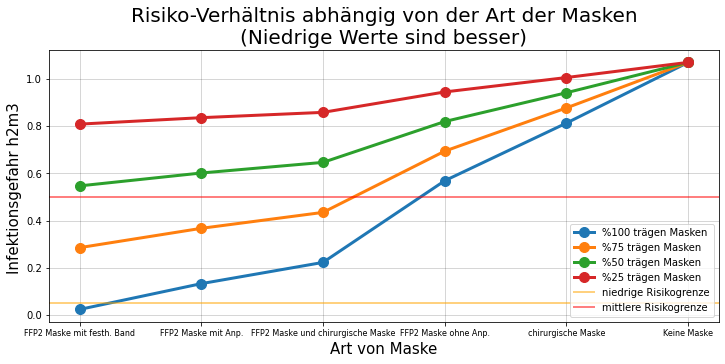

In [4]:
plt.figure(figsize=(12,5))
for people in df_dict.keys():
    plot_df = df_dict[people].sort_values(by=["Infection risk parameter", "Mask Type"])[["Infection risk parameter", "Mask Type"]]
    plt.plot(plot_df["Mask Type"], plot_df["Infection risk parameter"],'o-', linewidth='3', ms='10', label=f"%{int(float(people) * 100)} trägen Masken")
    plt.title("Risiko-Verhältnis abhängig von der Art der Masken\n(Niedrige Werte sind besser)", fontdict={'size': 20})
plt.axhline(y=0.05, color="orange", lw=2, alpha=0.5, label="niedrige Risikogrenze")
plt.axhline(y=0.5, color="r", lw=2, alpha=0.5, label="mittlere Risikogrenze")
plt.xticks(fontsize=8)
plt.grid(color='k', alpha=0.2)
plt.xlabel("Art von Maske", fontdict={'size': 15})
plt.ylabel("Infektionsgefahr h2m3 ", fontdict={'size': 15})
plt.legend()
plt.savefig("Mask Efficiency")
plt.show()